Rapport : Quantitative Structure-Activity Relationship
Equipe : ahac1101 / khao1201 / taim1201 / wanc1101 

## **1.a - Réprésentation des données : Analyse des attributs**

In [4]:
# Importation des librairies
import pandas as pd
import numpy as np
# Paramètres d'affichage des DataFrames
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# librairies de visualisation
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import seaborn as sns
import plotly.graph_objects as go

# Librairies d'algorithmes de calcul
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest, mutual_info_classif


In [8]:
# Lecture des données du xlsx
data_file = "QSAR_dataset.xlsx"
# Stockage des données dans un dataframe
data = pd.read_excel(data_file,index_col=0)
# Affichage de la taille pour avoir une idée de la quantité de données/attributs
print(f"Le dataset QSAR possède {data.shape[1]} attributs et {data.shape[0]} données.")

Le dataset QSAR possède 75 attributs et 154 données.


##### **1.a.1. Analyse des critères statistiques des attributs avant prétraitrement**

In [649]:
# Statistiques descriptives des attributs
data.describe()

,apol,ASA+,ASA-,a_count,a_donacc,a_heavy,a_hyd,a_IC,a_nC,a_nCl,a_nF,a_nH,balabanJ,bpol,CASA+,CASA-,chi0,chi0v,chi0v_C,chi0_C,chi1,chi1v,chi1v_C,chi1_C,DASA,DCASA,dens,density,diameter,dipole,h_logP,h_logS,logP(o/w),logS,mr,npr2,PC+,PC-,PEOE_VSA_NEG,PEOE_VSA_PNEG,PEOE_VSA_POL,PEOE_VSA_PPOS,petitjean,petitjeanSC,pmi,pmi2,pmi3,radius,rgyr,RPC-,rsynth,SlogP,SMR,std_dim1,std_dim2,std_dim3,TPSA,VAdjEq,VAdjMa,VDistEq,VDistMa,vdw_area,vdw_vol,vol,VSA,vsa_acc,vsa_hyd,vsa_pol,vsurf_A,vsurf_R,vsurf_S,vsurf_V,Weight,zagreb
count,154.000000,152.000000,153.000000,154.000000,154.000000,153.000000,154.000000,153.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,1.470000e+02,141.000000,136.000000,154.000000,154.000000
mean,34.610698,105.781739,359.928668,23.909091,0.292208,18.875817,17.350649,33.912102,11.649351,3.110390,2.571429,5.038961,2.714214,12.106199,219.625677,1107.378109,14.303269,12.198969,6.255169,7.238880,8.665561,6.612845,3.451360,4.660407,266.639368,921.074073,1.431223,1.094136,8.636364,1.589164,6.309915,-6.398987,6.412761,-6.898967,6.975075,0.852083,2.537487,-2.784312,208.924678,9.755466,15.080398,5.324932,0.438692,0.797642,5145.701918,4292.409483,4832.377483,4.785714,3.554500,0.149592,0.234911,5.785759,7.231751,2.887565,1.411958,0.703366,15.801558,0.524767,5.264981,2.825820,8.094493,259.668901,144.081974,246.203734,273.307303,8.076532,239.944812,9.086768,2.379611,-6.802721e+08,-66.497364,-2.501405,359.813016,101.350649
std,5.951534,62.391286,111.225998,4.895461,0.862625,5.596428,5.028718,9.714722,2.472152,2.954031,6.335765,3.838033,1.710695,7.573657,206.638085,1246.362768,5.194629,3.087648,1.447586,1.873913,2.115781,1.501245,1.047979,1.683055,144.691041,1232.204660,0.347068,0.294912,1.729476,2.159977,1.943933,1.625585,1.922318,2.044863,1.603270,0.111952,2.062802,2.355922,59.180178,15.463769,24.734093,10.188526,0.057631,0.160078,3385.386067,3112.597016,3159.418007,0.766661,0.610114,0.078984,0.341899,1.940097,1.668464,0.546035,0.254090,0.460910,20.695163,0.095753,0.346538,0.293186,0.777729,58.299787,13.843568,48.217762,52.783753,14.721655,59.915749,15.129738,2.637952,8.247861e+09,73.647379,2.807324,132.955027,33.487395
min,17.148172,8.778115,122.917570,12.000000,0.000000,10.000000,6.000000,12.000000,6.000000,0.000000,0.000000,0.000000,1.464454,2.520000,39.416298,170.115160,6.811555,5.003862,3.000000,3.000000,4.698377,2.668598,1.250000,1.250000,0.030300,0.045450,0.873103,0.620973,5.000000,0.000150,0.018347,-12.304079,-0.726000,-14.071490,2.991871,0.500026,1.062000,-10.980000,69.183167,0.000000,0.000000,0.000000,0.200000,0.250000,568.416630,408.216950,568.416630,3.000000,2.105879,0.081967,0.000000,0.189200,3.073050,1.508722,0.983466,0.000231,0.000000,0.266657,4.321928,2.107732,6.305622,131.061520,112.240073,116.250000,140.102050,0.000000,67.651054,0.000000,0.011998,-1.000000e+11,-209.769584,-8.247237,128.174000,46.000000
25%,31.534723,70.909811,330.864750,22.000000,0.000000,17.000000,16.000000,30.541887,12.000000,0.000000,0.000000,3.000000,1.906260,6.892828,117.247280,539.355285,11.949383,10.393762,6.096688,7.057960,7.958635,5.944405,3.236538,4.037457,204.843430,378.222350,1.228762,0.917542,8.000000,0.207287,5.344490,-7.359139,5.582320,-8.217000,5.737753,0.797710,1.512000,-2.512000,176.738710,0.000000,0.000000,0.000000,0.444444,0.800000,3294.154200,2509.562575,2980.993750,4.250000,3.242875,0.105173,0.000000,4.321315

In [650]:
# Types des attributs
print(data.dtypes)

Class             object
apol             float64
ASA+             float64
ASA-             float64
a_count            int64
a_donacc           int64
a_heavy          float64
a_hyd              int64
a_IC             float64
a_nC               int64
a_nCl              int64
a_nF               int64
a_nH               int64
balabanJ         float64
bpol             float64
CASA+            float64
CASA-            float64
chi0             float64
chi0v            float64
chi0v_C          float64
chi0_C           float64
chi1             float64
chi1v            float64
chi1v_C          float64
chi1_C           float64
DASA             float64
DCASA            float64
dens             float64
density          float64
diameter           int64
dipole           float64
h_logP           float64
h_logS           float64
logP(o/w)        float64
logS             float64
mr               float64
npr2             float64
PC+              float64
PC-              float64
PEOE_VSA_NEG     float64


#### **1.a.2. Prétraitement des données**

**Traitement des valeurs dupliquées** \
Avant de commencer tout prétraitement, nous avons procédé à la suppression des données dupliquées.

In [651]:
# Suppression d'objets dupliqués
data = data.drop_duplicates()
data.duplicated().sum()
print(f"Le dataset QSAR, sans données dupliquées, possède finalement {data.shape[1]} attributs et {data.shape[0]} données.")

Le dataset QSAR, sans données dupliquées, possède finalement 75 attributs et 132 données.


**Normalisation ?**\
Nous souhaitions procéder à une normalisation de nos données dans la phase de prétraitement, cependant, puisqu'on sera possiblement amenés à l'application de l'algorithme PCA, nous ne le ferons pas. La normalisation égalise le poids de chaque attribut, ce qui est contraire au PCA, fondé sur l'importance relative de chaque dimension.

**Traitement des valeurs aberrantes** \
Nous avons décidé de traiter les valeurs aberrantes avant de procéder à l'imputation. L'imputation se fera à partir dun modèle construit sur les données, elles doivent donc être nettoyées avant.

In [652]:
# Nous allons utiliser plusieurs des subplots pour l'affichage des boxplots
# Puisque les données ont étés normalisées, leur boxplot n'ont pas l'échelle,
# d'où une volonté de els séparer
fig = make_subplots(rows=15, cols=5)
all_attributes = list(data.columns)
c = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, 79)]
# Index qu'on utilisera pour s'assurer qu'on ne sera pas or index
ind = 0

for row in range(1,16):
    for col in range(1,6):
        fig.add_trace(go.Box(
            y=data[all_attributes[ind]],
            name=all_attributes[ind],
            jitter=0.5,
            whiskerwidth=0.2,
            marker_color=c[ind],
            line_width=1),
            row =row,col=col
            )
        ind += 1
        if ind == 79:
            break

fig.update_layout(height=3000, width=1200, title_text="Boxplot des 79 attributs")
fig.show()

Il serait maintenant intéressant d'avoir des valeurs numériques du taux de valeurs aberrantes par attribut. Si l'on remarque une proportion trop élevée de valeurs aberrantes pour un attribut, il sera envisagé de le supprimer. Sachant que nous ignorerons les valeurs aberrantes comprises dans dans les attributs correspondants à la classe, puisque c'est l'attribut cible.

In [653]:
data_no_class = data.drop(columns=["Class"])

In [654]:
def count_outliers(attribute):
    Q1 = data[attribute].quantile(q = 0.25)
    Q3 = data[attribute].quantile(q = 0.75)
    IQR = Q3 - Q1
    # Limites de l'intervalle
    high_outlier,low_outlier = Q3+1.5*IQR,Q1-1.5*IQR
    # Récupération des valeurs aberrantes
    outliers = data[(data[attribute] > high_outlier) | (data[attribute] < low_outlier)]
    return (outliers.shape[0] /154)*100

In [655]:
# Obtention du nombre de valeurs aberrantes par attribut
rate_of_outliers = []
for attribute in list(data_no_class.columns):
    r = count_outliers(attribute)
    rate_of_outliers.append(r)

In [656]:
colors_rate_outliers = []
# iste pour l'affichage en couleur du graphe suivant
for k in rate_of_outliers:
    if k <= 5 :
        colors_rate_outliers.append('#B6E2A1')
    elif k >= 15 :
        colors_rate_outliers.append('crimson')
    else : 
        colors_rate_outliers.append('rgb(158,202,225)')

In [657]:
fig = go.Figure([go.Bar(x=list(data_no_class.columns), y=rate_of_outliers,text=rate_of_outliers, marker_color=colors_rate_outliers)])
fig.update_traces(marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6,texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(yaxis=dict(title='Pourcentage de valeurs aberrantes'),
                  xaxis=dict(title="Attributs"),title_text='Nombre de valeurs aberrantes par attribut (sans les attributs de classe)')
fig.show()

On peut voir d'après le graphe précédent, en rouge les attributs dont la proportion de valeur aberrante dépasse les 15% de données totale, et en vert ceux dont ce pourcentage est inférieur à 5%. On remarque que la proportion de valeurs aberrantes est très élevée dans les données, ce qui nous a poussé à les conserver. \
À ce niveau du sujet, un point de vue expert sur la signification des attributs et donc possiblement l'origine de ces valeurs aberrantes nous aurait possiblement guidés vers un autre choix, mais sans ceci, nous préférons les considérer comme des données "correctes".

**Traitement des données manquantes**

*Pour alléger la rédaction, nous avons décidé de surnommer les attributs aux données manquantes les ADM.*

In [658]:
# Détermination du type, du nombre et du pourcentage de valeurs manquantes par attribut
nb_m = data_no_class.isnull().sum().sort_values()
ratio_m = (data_no_class.isnull().sum()/data_no_class.shape[0]).sort_values()

In [659]:
manquant = pd.concat([nb_m, ratio_m], axis=1, sort=False)

In [660]:
# Affichage de ces données
df_manquants = pd.DataFrame({'Types': data_no_class[list(manquant.index.values)].dtypes,
                       'Nb manquants': nb_m,
                      '% de manquants': ratio_m,})
# On ne se concentre que sur les attributs aux valeurs manquantes
df_ADM = df_manquants[df_manquants["Nb manquants"]>0]
print(df_ADM)

           Types  Nb manquants  % de manquants
a_heavy  float64             1        0.007576
ASA-     float64             1        0.007576
a_IC     float64             1        0.007576
ASA+     float64             2        0.015152
vsurf_R  float64             7        0.053030
vsurf_S  float64            12        0.090909
vsurf_V  float64            16        0.121212


In [661]:
print("On a au total ",df_ADM["Nb manquants"].sum(), "valeurs manquantes dans nos données, soit une proportion de : ",
      round((40/154),3)*100,'%.')

On a au total  40 valeurs manquantes dans nos données, soit une proportion de :  26.0 %.


Nous avons décidé de procéder au traitement des données manquantes par imputation, au lieu de simplement supprimer les dites données, car elles représentent environs du dataset.

Tout d'abord, on observe que tous les attributs manquants sont numériques. De plus, on remarque que la proportion de données manquantes est différente pour chaque attribut, on n'est donc pas dans le cas du MMCA (Données manquantes de Manière Complètement Aléatoire)<sup>**1**</sup>. On considère que nos données sont dans le cas MA (Manquantes Aléatoirement), car c'est la situation la plus courante<sup>**2**</sup>, même s'il est en réalité différencier ces deux cas sans une vision experte de la représentation de ces données.. Pour traiter les données MA il y a deux possibilités qui s'offrent à nous<sup>**3**</sup> :
- Imputation par régression linéaire
- Imputation multiple (On choisit kNN car c'est un algorithme qu'on a étudié en cours)

Nous avons choisi d'opter pour l'imputation kNN, car celle-ci peut effectuer une imputation plus simplement même s'il y a des valeurs manquantes dans le dataset.

In [662]:
# Liste des attributs avec des données manquantes
missing_attributes = ["a_IC","a_heavy","ASA-","ASA+","vsurf_R","vsurf_S","vsurf_V"]

**Imputation KNN** 


Pour l'imputation multiple, nous allons procéder à une imputation kNN avec KNNImputer<sup>**4**</sup>  de la librairie scikit-learn. Il n'y a pas besoin, lors de l'imputation d'une valeur manquante, de retirer les autres ADM : le kNN Imputer, fonctionnant sur l'lagorithme du plus proche voisin, détermine la proximité entre deux points qu'à travers les attributs complets. \

*Nombre de voisins k* \
Le nombre de voisins ne peut pas être déterminé par une évaluation des résultats après l'imputation, puisqu'il n'y a pas de données auxquelles on peut comparer les résultats obtenus. \
Nous avons donc choisi, de manière arbitraire k = $\sqrt{Nombre De Lignes}$, soit k = $\sqrt{132}$ ≈ 11 \

*La métrique*  \
En ce qui concerne la métrique<sup>**5**</sup> :
- Nous n'avons pas choisi la distance de Manhattan, car elle suppose que toutes les unités sont comparables, alors qu'on a par exemple les attribtus "Weights', "Density", "Diameter", qui sont certainement d'unités différentes ;
- Ni la distance cosinusoïdale, car il suppose que toutes les caractéristiques sont d'égales importance.
Comme pour le nombre de voisins, sans moyen concret d'évaluer la meilleure métrique, nous avons décidé d'opter pour la distance euclidienne.

In [663]:
def kNNimputation(data):
    # Imputation kNN, avec pour poids la distance des points
    imputer = KNNImputer(n_neighbors=11,weights="distance",metric="nan_euclidean")
    imputed = imputer.fit_transform(data)
    data_kNNimputed = pd.DataFrame(imputed, columns=data.columns)
    # Retourne le dataframe remplie
    return data_kNNimputed
            

In [664]:
# On procède à l'imputation
# elle ne fonctionne pas avec des attributs non numériques
# d'oùle choix de data_no_class pour l'effectuer
df_clean = kNNimputation(data_no_class)

In [665]:
# Vérification du nombre de valeurs aberrantes
nb_m = df_clean.isnull().sum().sort_values()
ratio_m = (df_clean.isnull().sum()/data_no_class.shape[0]).sort_values()
print(f"Nombre de valeurs manquantes : {nb_m.sum()}")


Nombre de valeurs manquantes : 0


**Sauvegarde des données nettoyées obtenues**

In [666]:
# On récupère la colonne classe
df_clean = df_clean.assign(Class=data["Class"].values)
# ====== Mise en commentaire pour éviter la création d'un fichier à chaque exécution
# df_clean.to_excel("clean_QSAR_dataset.xlsx")  
# =======

#### **1.a.3. Sélection des 10 meilleurs attributs**

In [667]:
# Import des données nettoyées
data_file = "clean_QSAR_dataset.xlsx"
# Stockage des données dans un dataframe
data = pd.read_excel(data_file,index_col=0)

Afin de déterminer les 10 meilleurs attributs, nous utilisons la méthode "Select K Best", qui utilise des mesures statistiques pour classer les attributs.
La méthode SlectKBest de la librairie sklearn possède deux attributs<sup>**6**</sup>:
- K : le nombre de meilleurs attributs que l'on souhaite choisir
- score_func : la fonction utilisée pour évaluer les attributs

**Choix de score_func** \
Nous utilisons SelectKBest dans un but de classification, on a donc les possibilités suivantes pour score_func : 
- chi_2 : *Plus pratique dans le cas d'attributs non numériques*
- mutual_info_classif : *Fonctionne avec des datasets aux attributs numériques ou non. Détermine la quantité d'informations partagée entre les attributs et l'attribut cible. Les attributs aux plus hauts scores sont ceux fournissant le plus d'informations sur l'attribut cible.*
- f_classif : *Basé sur l'analyse de la variance (ANOVA), mesure la dépendance linéaire entre deux variables. Les attributs aux plus hauts score sont ceux dépendant de l'attribut cible.* 

D'après les informations précédentes, notre choix s'est porté sur mutual_info_classif, car nous ne voulons pas les meilleurs attributs qui dépendent de l'attribut "Class", mais ceux qui permettent d'avoir plus d'information sur ce dernier.

In [668]:
selector = SelectKBest(mutual_info_classif, k=10)
X = data.drop(columns=["Class"])
y = data["Class"]
selector.fit_transform(X, y)

array([[  1.5986819 ,  10.113732  ,  -9.3698997 , ...,   6.9222002 ,
          7.0426002 , 399.21936   ],
       [  0.63803971,   2.9311595 ,  -3.2627599 , ...,   2.8397999 ,
          4.3948002 , 136.57939   ],
       [  1.236138  ,  10.476893  , -11.15416   , ...,   9.8875999 ,
         10.1978    , 345.43402   ],
       ...,
       [  0.94905031,   6.3414574 ,  -6.7484198 , ...,   5.9671998 ,
          7.1918001 , 239.94559   ],
       [  0.65310049,   4.0384159 ,  -5.1406398 , ...,   3.993     ,
          6.1454    , 174.03706   ],
       [  1.0050656 ,   6.0084519 ,  -7.6140499 , ...,   6.1996002 ,
          7.3759999 , 226.32581   ]])

*selector* contient les valeurs des attributs sélectionnés, il faut donc les comparer au dataset pour obtenir le nom des 10 meilleurs attributs.

In [669]:
# Tableau des index des attributs sélectionnés
selected_attributes_index = selector.get_support(indices=True)
df_BA = data.iloc[:,selected_attributes_index]
best_attribute = list(df_BA.columns)
print(f"Les 10 meilleurs attributs sont : {best_attribute}")

Les 10 meilleurs attributs sont : ['density', 'h_logP', 'logS', 'mr', 'PC+', 'PC-', 'RPC-', 'SlogP', 'SMR', 'vdw_area']


#### **1.a.4. Visualisation des 10 meilleurs attributs**

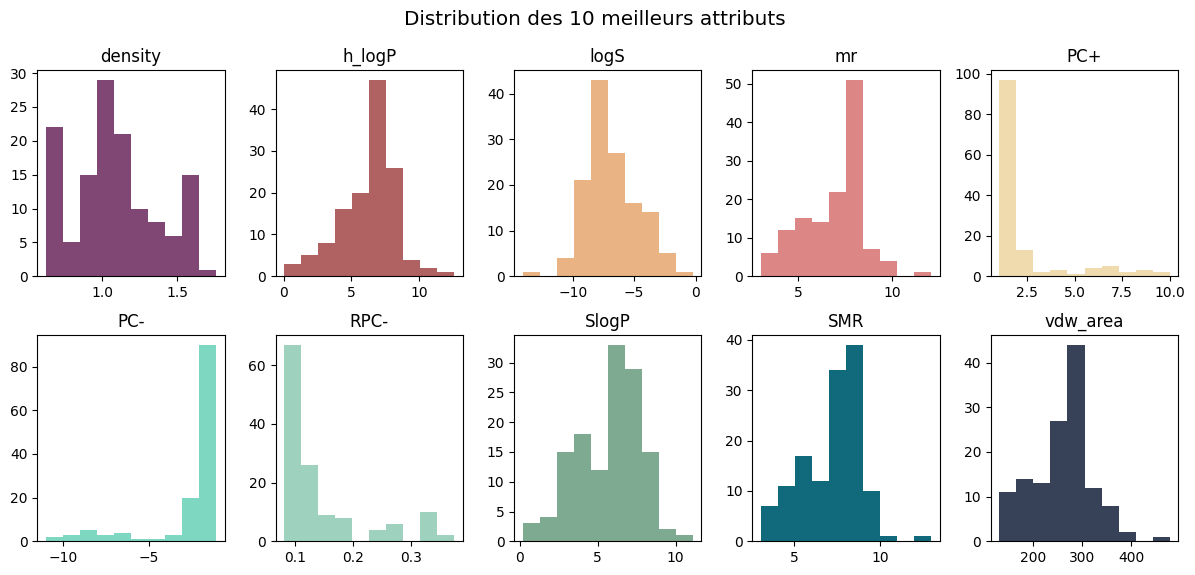

In [670]:

colors = ["#804674","#B06161","#E9B384","#DC8686","#F0DBAF","#7ED7C1","#9ED2BE","#7EAA92","#116A7B","#374259"]
fig = plt.figure(figsize=(12,6))
st = fig.suptitle("Distribution des 10 meilleurs attributs", fontsize="x-large")


for k in range(0,10):
    ax1 = fig.add_subplot(2,5,k+1)
    ax1.hist(df_BA[best_attribute[k]],color=colors[k])
    ax1.set_title(best_attribute[k])

fig.tight_layout()

st.set_y(0.95)
fig.subplots_adjust(top=0.85)

## **1.b - Réprésentation des données : Transformation ACP**

<Axes: >

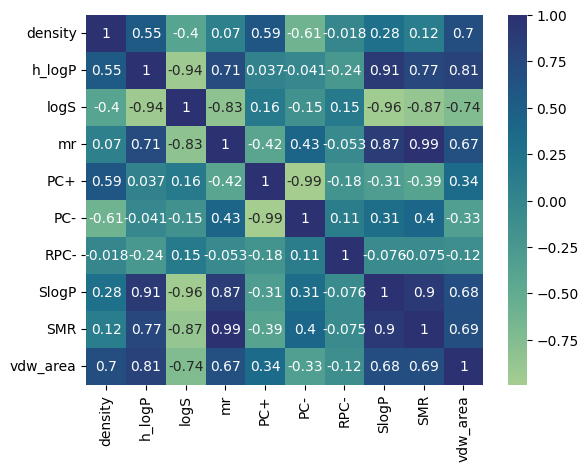

In [671]:
BA_corr = df_BA.corr()
sns.heatmap(BA_corr,annot=True,cmap="crest")

On peut observer que sur les 45 coefficients de corrélation (doublons et diagonale exclus), **23 coeffficients** soit **51% du total**  dont la valeur absolue est => 0.65 : On considère ces attributs corrélés. Parmi ceux ci,**11 coeffficients** soit **24% du total**  ont la valeur absolue => 0.85 : On considère ces attributs très corrélés.

Au vu des taux de corrélation, on peut en déduire que l'application du ACP est **nécessaire** pour éviter toute redondance.


# EST CE QUE VOUS VOULEZ QUE JE CODE CES CALCULS ?

**Calcul de corrélation par classe** \
Nous allons produire cinq matrices de corrélation pour chaque classe, et les comparer.

In [672]:
# Création des dataframe pour chaque classe
df_Class_m2 = data.loc[data['Class'] == "Class -2"]
df_Class_m1 = data.loc[data['Class'] == "Class -1"]
df_Class_0 = data.loc[data['Class'] == "Class 0"]
df_Class_1 = data.loc[data['Class'] == "Class 1"]
df_Class_2 = data.loc[data['Class'] == "Class 2"]

# Conservation que des 10 meilleurs attributs
df_Class_m2 = df_Class_m2.filter(best_attribute)
df_Class_m1 = df_Class_m1.filter(best_attribute)
df_Class_0 = df_Class_0.filter(best_attribute)
df_Class_1 = df_Class_2.filter(best_attribute)
df_Class_2 = df_Class_2.filter(best_attribute)


In [673]:
# Matrice de corrélation de chaque classe
C2_corr = df_Class_2.corr()
C1_corr = df_Class_1.corr()
C0_corr = df_Class_0.corr()
Cm1_corr = df_Class_m1.corr()
Cm2_corr = df_Class_m2.corr()

Text(0.5, 1.0, 'Heatmap de Class -2')

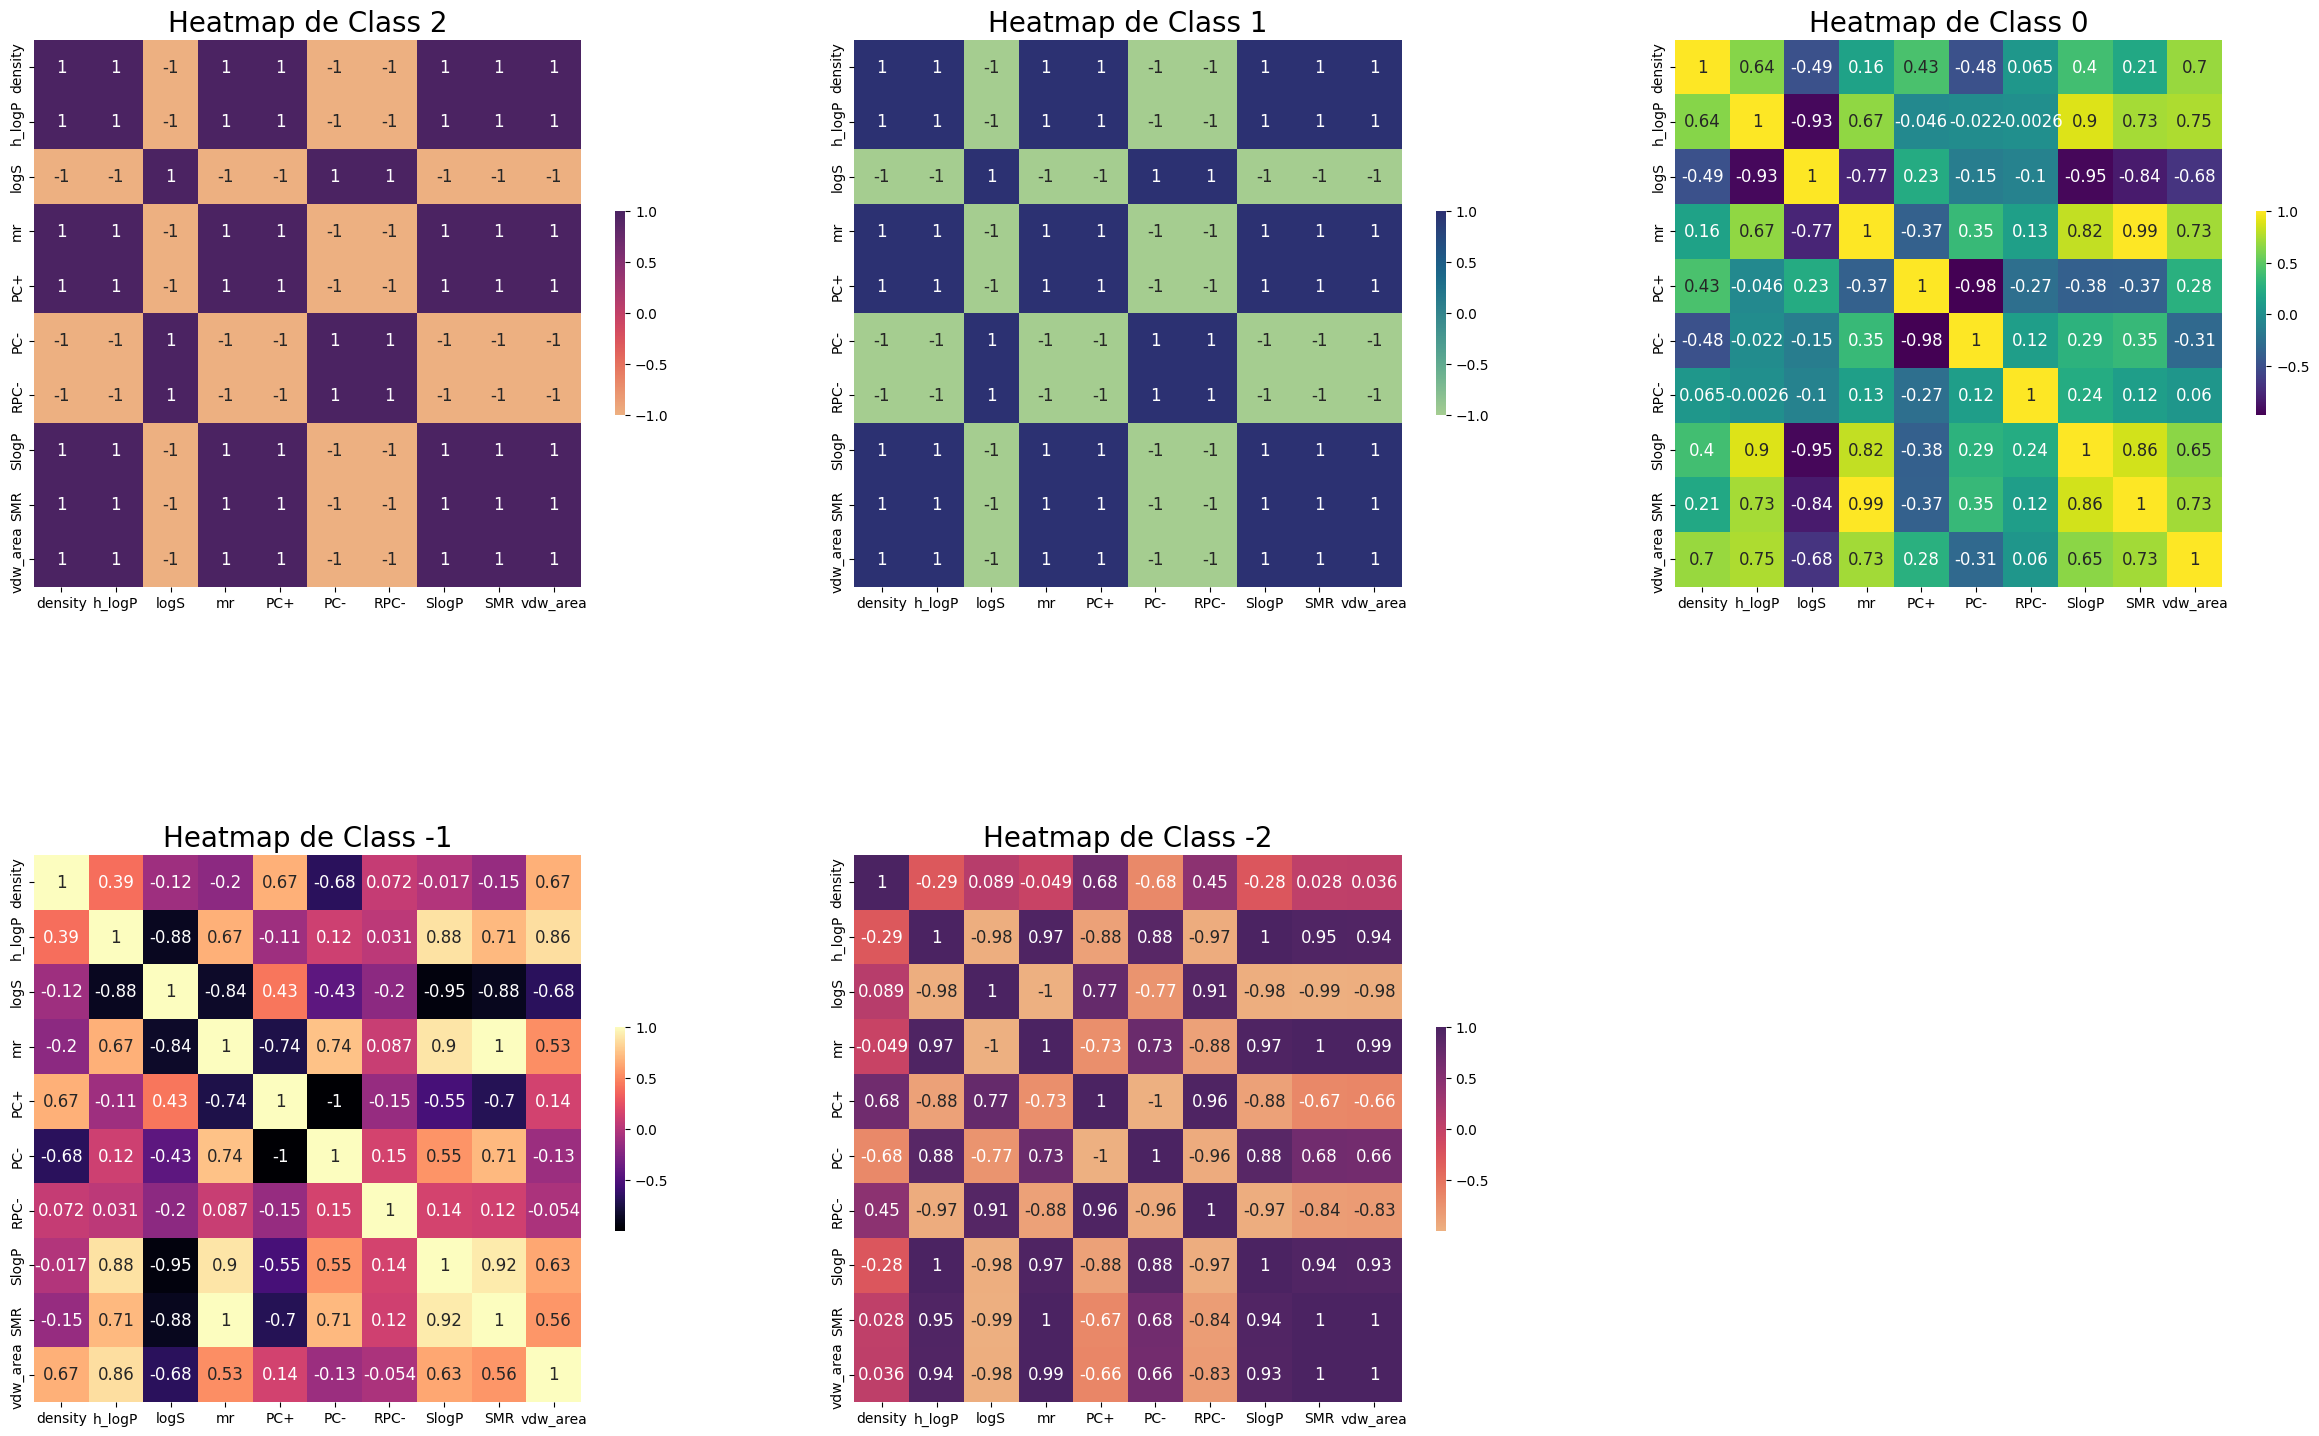

In [674]:
fig = plt.figure(figsize = (30,30)) # width x height
ax1 = fig.add_subplot(3, 3, 1) # row, column, position
ax2 = fig.add_subplot(3, 3, 2)
ax3 = fig.add_subplot(3, 3, 3)
ax4 = fig.add_subplot(3, 3, 4)
ax5 = fig.add_subplot(3, 3, 5)

# We use ax parameter to tell seaborn which subplot to use for this plot
sns.heatmap(data=C2_corr, ax=ax1, cmap = "flare", square=True, cbar_kws={'shrink': .3}, annot=True, annot_kws={'fontsize': 12})
sns.heatmap(data=C1_corr, ax=ax2, cmap = "crest", square=True, cbar_kws={'shrink': .3}, annot=True, annot_kws={'fontsize': 12})
sns.heatmap(data=C0_corr, ax=ax3, cmap = "viridis", square=True, cbar_kws={'shrink': .3}, annot=True, annot_kws={'fontsize': 12})
sns.heatmap(data=Cm1_corr, ax=ax4, cmap = "magma", square=True, cbar_kws={'shrink': .3}, annot=True, annot_kws={'fontsize': 12})
sns.heatmap(data=Cm2_corr, ax=ax5, cmap = "flare", square=True, cbar_kws={'shrink': .3}, annot=True, annot_kws={'fontsize': 12})

ax1.set_title("Heatmap de Class 2",fontsize = 20)
ax2.set_title("Heatmap de Class 1",fontsize = 20)
ax3.set_title("Heatmap de Class 0",fontsize = 20)
ax4.set_title("Heatmap de Class -1",fontsize = 20)
ax5.set_title("Heatmap de Class -2",fontsize = 20)

On peut constater que les matrices de corrélations sont différentes pour chaque classes, excepté les classes *Class 1* et *Class 2*.

# EST CE QUE VOUS VOULEZ QUE JE CODE CA ? JE PEUX TENTER UNE MESURE DE SIMILARITÉ SI VOUS LE SOUHAITEZ ENTRE LES MATRICES

2 - Mesures de distance

a)

b)

3 - Choix du modèle de classification

b)

4 - Application

In [675]:
#okokoibn
def fun():
    return 897

### **Références**

1. https://stefvanbuuren.name/fimd/sec-MCAR.html
2. https://medium.com/analytics-vidhya/different-types-of-missing-data-59c87c046bf7
3. https://www.datacamp.com/tutorial/techniques-to-handle-missing-data-values
4. https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html
5. https://www.linkedin.com/advice/3/what-most-effective-distance-metrics-optimizing-xndwc
6. https://medium.com/@Kavya2099/optimizing-performance-selectkbest-for-efficient-feature-selection-in-machine-learning-3b635905ed48#:~:text=SelectKBest%20is%20a%20type%20of,score%20and%20rank%20the%20features.